# Machine Learning: Lab 3
## Classification
TA: Bryan Coulier (bryan.coulier@kuleuven.be)

### Simple Classification
Create and train the following classification models for the iris dataset:
- K-nearist neighbor (n=5)
- Support-Vector machines
- Gaussian Naive Bayes
- Decision Tree Classifier

Determine the accuracy of each trained model.

Importeren van alles 

In [155]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.utils import resample


In [156]:
%matplotlib inline

iris = datasets.load_iris()
X = iris.data
y = iris.target

opsplitsen van de dataset 

In [157]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

initializeren van de modellen met de juiste parameters.

In [158]:
models = [
    ('K-Nearest Neighbors (n=5)', KNeighborsClassifier(n_neighbors=5)),
    ('Support Vector Machine', SVC(random_state=42)),
    ('Gaussian Naive Bayes', GaussianNB()),
    ('Decision Tree Classifier', DecisionTreeClassifier(random_state=42))
]

trainen , voorspellen en evauleren van elk model

In [159]:
results = {}
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

Uitprinten van de resultaten

In [160]:
for model_name, acc in results.items():
    print(f"{model_name}: {acc:.4f}")

K-Nearest Neighbors (n=5): 1.0000
Support Vector Machine: 1.0000
Gaussian Naive Bayes: 1.0000
Decision Tree Classifier: 1.0000


De Iris dataset is een heel kleine dataset die 'te perfect' is. Hierdoor zijn de bekomen resultaten perfect.

### Cross-validation
Determine the mean accuracy and standard deviation with a confidence interval of 98% for the KNN-model by using 5-fold cross-validation.

Explain why you chose a certain method to determine the confidence interval and how it is calculated.

What does this confidence interval tell you about the accuracy of the model?

In case you assume a normal distribution, justify this.


probleem : 5 samplepunten , dus oplossen met bootstrapping : dataset x aantal keer resampelen en dan op de geresampelde dingen een model maken 
het resamplen kan met duplicaten
een sample er meerdere keren insteken 
5 fold cross validatai kan je doen voor alle 5 
daarop kan je totaal gemiddelde nauwkeurigheid berekenen
betrouwbaarheidsinterval berekenen
je moet een normaal distributie hebben 

Initializeren van de KNN classificatie 

In [161]:
knn = KNeighborsClassifier(n_neighbors=3)

uitvoeren van 5-fold cross-validatie

In [162]:
cv_scores = cross_val_score(knn, X, y, cv=5)

Bootsrappen , met 10000 sample's , en het genereren van bootstrap sample's van de 5 cv scores

In [163]:
n_bootstraps = 10000  
bootstrap_means = []
for _ in range(n_bootstraps):
    resampled_scores = np.random.choice(cv_scores, size=5, replace=True)
    bootstrap_means.append(np.mean(resampled_scores))

Berekenen van de statistieken

In [164]:
mean_accuracy = np.mean(bootstrap_means)
std_accuracy = np.std(bootstrap_means, ddof=1)

98% betrouwbaarheidsinterval

In [165]:
lower_bound = np.percentile(bootstrap_means, 1)  # 1st percentile
upper_bound = np.percentile(bootstrap_means, 99)  # 99th percentile

uitprinten van alles

In [166]:
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Standard Deviation: {std_accuracy:.4f}")
print(f"98% Confidence Interval: {mean_accuracy:.4f} ± {confidence_interval:.4f}")

Mean Accuracy: 0.9668
Standard Deviation: 0.0094
98% Confidence Interval: 0.9668 ± 0.0155


plotten van alles

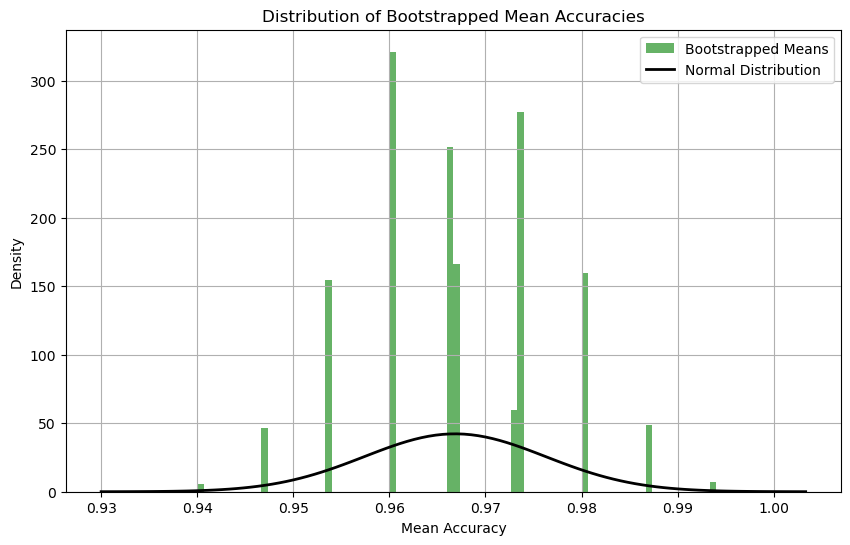

In [167]:
plt.figure(figsize=(10, 6))
plt.hist(bootstrap_means, bins=100, density=True, alpha=0.6, color='g', label='Bootstrapped Means')

# noramle distributie curve overplotten
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_accuracy, std_accuracy)
plt.plot(x, p, 'k', linewidth=2, label='Normal Distribution')

plt.title('Distribution of Bootstrapped Mean Accuracies')
plt.xlabel('Mean Accuracy')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

#### Hyper-parameter Tuning
Use Grid search to tune the hyperparameters for Gaussian Naive Bayes and retrain the model with these hyper-parameters. 

Use 5-fold Cross Validation for the grid search.

Print out the selected Hyperparameter values and their grid search score.

Determine the accuracy of the retrained model, and compare it to the original model.

opstellen van origineel model

In [168]:
original_model = GaussianNB()
original_model.fit(X_train, y_train)

GaussianNB()

huperparameter tuning aan de hand van grid search

In [169]:
param_grid = {'var_smoothing': np.logspace(-9, -3, 7)}
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])},
             scoring='accuracy')

beste hyperparameters en de score extraheren

In [170]:
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_model = grid_search.best_estimator_

bootstrappen

In [171]:
n_bootstraps = 1000
original_accs = []
tuned_accs = []

for _ in range(n_bootstraps):
    # hersampelen van de test data 
    X_boot, y_boot = resample(X_test, y_test, replace=True)
    
    # berekenen van de de nauwkeurigheid van de modellen op de hersampelde data
    original_accs.append(accuracy_score(y_boot, original_model.predict(X_boot)))
    tuned_accs.append(accuracy_score(y_boot, best_model.predict(X_boot)))

berekenen van de nodige statistieken

In [172]:
original_mean = np.mean(original_accs)
original_ci = np.percentile(original_accs, [2.5, 97.5])
tuned_mean = np.mean(tuned_accs)
tuned_ci = np.percentile(tuned_accs, [2.5, 97.5])

Uitprinten van de resulaten

In [173]:
print("Selected Hyperparameters:", best_params)
print("Grid Search Best CV Score: {:.4f}".format(best_score))
print("\nOriginal Model Bootstrapped Accuracy: {:.4f} (95% CI: {:.4f}-{:.4f})".format(
    original_mean, original_ci[0], original_ci[1]))
print("Tuned Model Bootstrapped Accuracy: {:.4f} (95% CI: {:.4f}-{:.4f})".format(
    tuned_mean, tuned_ci[0], tuned_ci[1]))

Selected Hyperparameters: {'var_smoothing': np.float64(1e-09)}
Grid Search Best CV Score: 0.9281

Original Model Bootstrapped Accuracy: 1.0000 (95% CI: 1.0000-1.0000)
Tuned Model Bootstrapped Accuracy: 1.0000 (95% CI: 1.0000-1.0000)


## Example
#### Problem statement

Given the "obesity_dataset.csv" containing information of individuals, the task is to train a machine learning model to predict whether an individual is overweight or not and which type of overweight they have.
A complete description of the dataset can be found in the paper.

Requirements:
* Preprocess the data to make it suitable for a machine learning model.
* Create a pipeline for you classifier.
* Use grid search or random search with 5 fold cross validation to find a good set of parameters for your classifier.
* Determine the mean accuracy of the best grid search model by using 5-fold cross validation and a confidence interval of 95%.
You can assume the accuracy is normally distributed here without justification.

bepalen of iemand overgewicht heeft of niet 
....
eerst preprocessing , we kunnen niet alles direct gebruiken 
classificatiemodel maken , bij voorkeur voorspellen wat er staat , en ook level van overgewicht 

ook scalen
gridsearch of random search
je hebt een normale distributie 
dus geen bootstrapping 

Inladen van de dataset en de kolommen indelen in categorische en numerieke kolommen

In [174]:
df = pd.read_csv('obesity_dataset.csv')
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

Opzetten van de pipeline

In [175]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])


Definieren van de hyperparameters voor RandomizedSearchCV

In [176]:
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}

Stratified 5-fold cross-validation

In [177]:

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


random search met cross-validation

In [178]:
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=stratified_cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

hyperparameter tuning

In [179]:
random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'Height',
                                                                                'Weight',
                                                                                'FCVC',
                                                                                'NCP',
                                                                                'CH2O',
                                                                                'FAF',
                                                                                'TUE']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                Simple...
                                                                                'CALC',
                                                                                'MTRANS'])])),
                                             ('classifier',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True, False],
                                        'classifier__max_depth': [None, 10, 20,
                                                                  30],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [100, 200,
                                                                     300]},
                   random_state=42, scoring='accuracy')

vinden van het beste model

In [180]:
best_pipeline = random_search.best_estimator_

score's evalueren

In [181]:
cv_scores = cross_val_score(best_pipeline, X, y, cv=stratified_cv)

berekenen van het betrouwbaarheidsinterval en de accurraatheid

In [182]:
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)
confidence_interval = 1.96 * (std_accuracy / np.sqrt(len(cv_scores)))

Uitprinten van de resulaten

In [183]:
print(f"Best Parameters: {random_search.best_params_}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"95% Confidence Interval: ±{confidence_interval:.4f}")

Best Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20, 'classifier__bootstrap': False}
Mean Accuracy: 0.9436
95% Confidence Interval: ±0.0155
